Code to create and deploy the ml model on the backend. The data comes from ml.js and the time series data is created once on the backend. Make sure that eth_prices.csv is available in the directory of this script.

Format and code taken from: https://www.tensorflow.org/tutorials/structured_data/time_series 

In [3]:
%%capture installs
# Install tensorflow to the user system
!pip install tensorflow
!pip install tensorflowjs
!pip install numpy

In [4]:
%%capture imports
import os
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

# for hyperparameter selection
from itertools import product

# Import util functions from util.py
# Lots of the utils are from:
# https://www.tensorflow.org/tutorials/structured_data/time_series
from util import WindowGenerator
from util import split_window
from util import Baseline
from util import make_dataset
from util import compile_and_fit

In [5]:
# read and show the dataframe o fprices
df = pd.read_csv("eth_price.csv")

df.columns =['EpochDate', 'Price']
df.drop(columns=['EpochDate'], inplace=True)
df.head()

,Price
0,297.9225
1,290.5300
2,292.9725
3,315.8775
4,276.3650


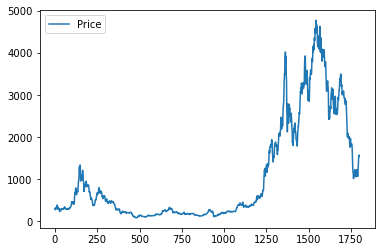

In [6]:
# view ETH price history
# This price history should be over the last 5 ish years
plot_cols = ['Price']
plot_features = df[plot_cols]
_ = plot_features.plot(subplots=True)

In [7]:
df.describe().transpose()
column_indices = {name: i for i, name in enumerate(df.columns)}

# train on entire dataframe
# only do this if we are not validating with train/test set etc...
# train_df = df

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [8]:
train_min = train_df.min()
train_max = train_df.max()

train_df = (train_df - train_min) / train_max
val_df = (val_df - train_min) / train_max
test_df = (test_df - train_min) / train_max

# Give this to the backend
print("train_min", train_min)
print("train_max", train_max)

train_min Price    83.5925
dtype: float64
train_max Price    1369.69
dtype: float64


In [10]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

# setup the window generator for the time series
# this is taken from the tutorial

WindowGenerator.make_dataset = make_dataset

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example
WindowGenerator.split_window = split_window

In [11]:
wide_window = WindowGenerator(
    input_width=30, label_width=1, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=['Price'])

wide_window

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30]
Label column name(s): ['Price']

In [14]:
%%capture training
# Here we do a hyperparameter sweep over some parameters to decide what are the best to deploy on our server
results = {}
models = {}

NUM_EPOCHS = 20
hidden_dimensionalities = [16, 32, 64]
learning_rates = [0.01, 0.001, 0.001]
num_lstm_layers = [1, 2, 3]

for dims, lr, lstm_layers in product(hidden_dimensionalities, learning_rates, num_lstm_layers):
    # Shape [batch, time, features] => [batch, time, lstm_units]
    model_def = [tf.keras.layers.LSTM(dims, return_sequences=True) for x in range(lstm_layers)]
    # Shape => [batch, time, features]
    model_def.append(tf.keras.layers.Dense(units=1))
    # Shape => [batch, time, features]
    model_def.append(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    curr_model = tf.keras.models.Sequential(model_def)
    history = compile_and_fit(curr_model, wide_window, learning_rate=lr)
    
    val_results = curr_model.evaluate(wide_window.val, verbose=0)
    print(val_results)
    results[str(dims) + "_" + str(lr) + "_" + str(lstm_layers)] = val_results
    models[str(dims) + "_" + str(lr) + "_" + str(lstm_layers)] = tf.keras.models.clone_model(curr_model)

In [15]:
# print out all of the model results
# lower is better on the validation set for this metric
for name, item in results.items():
    print(name, item)

16_0.01_1 [2.2205536365509033, 1.3588273525238037]
16_0.01_2 [2.6717171669006348, 1.501379370689392]
16_0.01_3 [2.8535871505737305, 1.5616440773010254]
16_0.001_1 [1.9618191719055176, 1.2664132118225098]
16_0.001_2 [2.355273962020874, 1.408608078956604]
16_0.001_3 [2.92671537399292, 1.5673598051071167]
32_0.01_1 [2.0221800804138184, 1.28415048122406]
32_0.01_2 [2.7426984310150146, 1.5277411937713623]
32_0.01_3 [2.7534801959991455, 1.5271846055984497]
32_0.001_1 [1.8515903949737549, 1.2190459966659546]
32_0.001_2 [2.3423264026641846, 1.3908814191818237]
32_0.001_3 [2.457423210144043, 1.430108904838562]
64_0.01_1 [2.128962278366089, 1.3263336420059204]
64_0.01_2 [3.097827196121216, 1.6357624530792236]
64_0.01_3 [3.3257834911346436, 1.7063405513763428]
64_0.001_1 [1.919879674911499, 1.245208740234375]
64_0.001_2 [2.174424886703491, 1.3208011388778687]
64_0.001_3 [2.2502453327178955, 1.361010193824768]


In [16]:
# save the best model to a format that is compatible with tensorflow.js
import tensorflowjs as tfjs

# aribitrary large value
best = 1e9
best_model = ""

for name, value in results.items():
    if value[1] < best:
        best_model = name

print("Best model parameters", best_model)
print("Best model losses", results[best_model])
        
tfjs.converters.save_keras_model(models[best_model], '.')

Best model parameters 64_0.001_3
Best model losses [2.2502453327178955, 1.361010193824768]


In [18]:
# View output on a dummy input
# 
a = np.array([
    0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25,
    0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4,])

a = np.expand_dims(a, axis=1)
a = a.reshape(-1, 30, 1)

b = tf.constant(a)
print(b.shape, models[best_model](b))

(1, 30, 1) tf.Tensor(
[[[0.49996275]
  [0.4998761 ]
  [0.49973947]
  [0.4995572 ]
  [0.49933562]
  [0.49908164]
  [0.4988019 ]
  [0.4985026 ]
  [0.49818933]
  [0.49786672]
  [0.49753875]
  [0.49720857]
  [0.49687862]
  [0.49655077]
  [0.4962262 ]
  [0.49590585]
  [0.49559003]
  [0.49527904]
  [0.4949728 ]
  [0.49467114]
  [0.4943738 ]
  [0.49408045]
  [0.49379078]
  [0.49350435]
  [0.49322087]
  [0.49294007]
  [0.49266154]
  [0.4923851 ]
  [0.4921105 ]
  [0.4918375 ]]], shape=(1, 30, 1), dtype=float32)
